Количество дубликатов: 0
Диабет 1 типа: 138
Диабет 2 типа: 130
Без диабета: 500
Распределение классов в обучающей выборке:
Outcome
1    800
0    400
Name: count, dtype: int64
Распределение классов в тестовой выборке:
Outcome
1    200
0    100
Name: count, dtype: int64


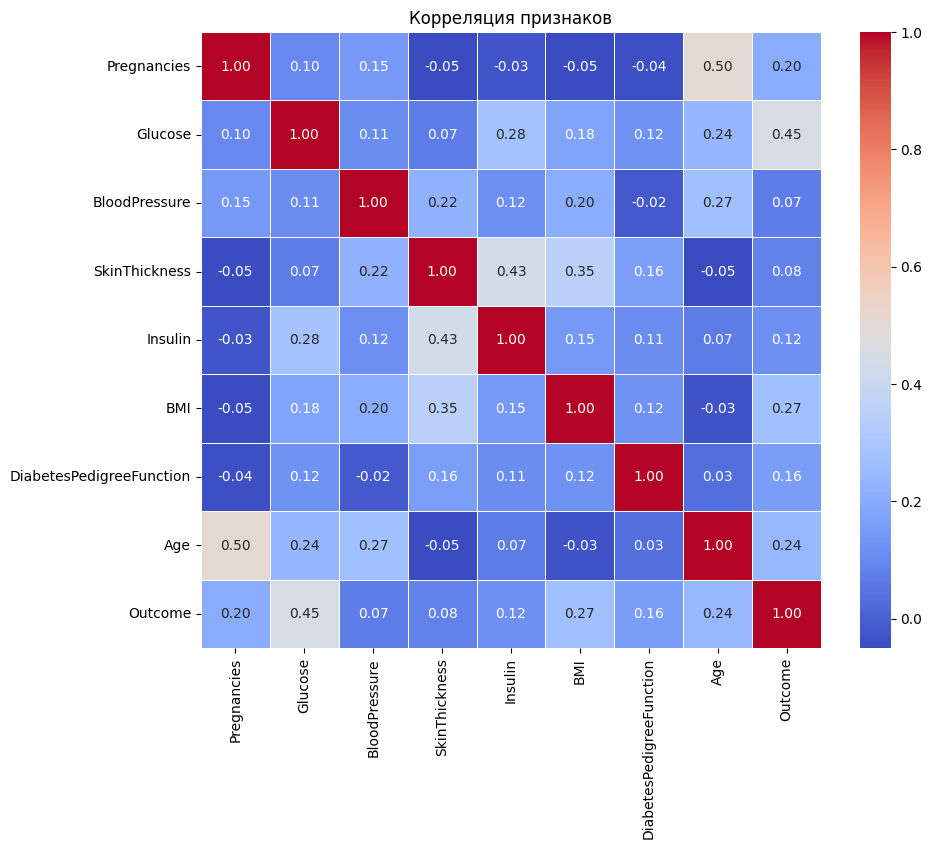

Логистическая регрессия:
Accuracy: 0.82
Precision: 0.83
Recall: 0.93

Случайный лес:
Accuracy: 0.91
Precision: 0.90
Recall: 0.97



In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE  # Для балансировки данных

# 1. Загрузка данных
df = pd.read_csv("diabetes.csv")

# 2. Оценка и удаление дубликатов
duplicates_count = df.duplicated().sum()
print(f"Количество дубликатов: {duplicates_count}")
df = df.drop_duplicates()

# 3. Определение групп по типу диабета
df_type1 = df[(df['Outcome'] == 1) & (df['Insulin'] == 0)]  # Диабет 1 типа
df_type2 = df[(df['Outcome'] == 1) & (df['Insulin'] > 0)]   # Диабет 2 типа
df_no_diabetes = df[df['Outcome'] == 0]  # Без диабета

# 4. Проверяем размер групп
print(f"Диабет 1 типа: {len(df_type1)}")
print(f"Диабет 2 типа: {len(df_type2)}")
print(f"Без диабета: {len(df_no_diabetes)}")

# 5. Определяем минимальный и максимальный классы
min_size = min(len(df_type1), len(df_type2), len(df_no_diabetes))
max_size = max(len(df_type1), len(df_type2), len(df_no_diabetes))

# 6. Балансировка классов (увеличиваем меньшие классы до размера самого большого)
def balance_class(df, target_size):
    while len(df) < target_size:
        df = pd.concat([df, df.sample(min(target_size - len(df), len(df)), replace=True)], ignore_index=True)
    return df

df_type1_balanced = balance_class(df_type1, max_size)
df_type2_balanced = balance_class(df_type2, max_size)
df_no_diabetes_balanced = balance_class(df_no_diabetes, max_size)

# 7. Объединяем сбалансированные группы
df_balanced = pd.concat([df_type1_balanced, df_type2_balanced, df_no_diabetes_balanced], ignore_index=True)

# 8. Разделяем данные на X и y
X = df_balanced.drop(columns=['Outcome'])
y = df_balanced['Outcome']

# 9. Разделение сбалансированной выборки (80% - обучение, 20% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 10. Проверяем сбалансированность в train и test
print("Распределение классов в обучающей выборке:")
print(y_train.value_counts())
print("Распределение классов в тестовой выборке:")
print(y_test.value_counts())

# 11. Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 12. Логистическая регрессия
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# 13. Случайный лес
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

corr_matrix = df_balanced.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляция признаков")
plt.show()

# 14. Оценка метрик вручную
def calculate_metrics(y_true, y_pred, model_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"{model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

calculate_metrics(y_test, y_pred_log, "Логистическая регрессия")
calculate_metrics(y_test, y_pred_rf, "Случайный лес")